<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [1]:
##### Your Code Here #####
import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(45)
tf.__version__

'1.14.0'

In [2]:
from tensorflow.keras.datasets import boston_housing
(X_train, y_train), (X_test, y_test) = boston_housing.load_data(path='boston_housing.npz', test_split=0.2, seed=45)

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((404, 13), (404,), (102, 13), (102,))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


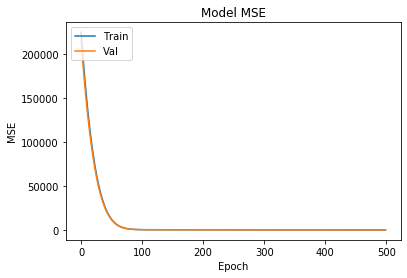

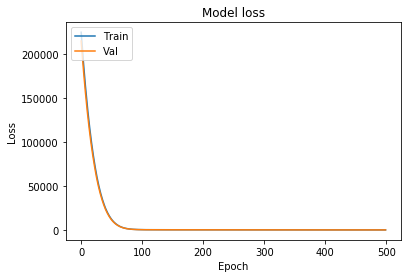

In [4]:
inputs = Input(shape=(13,))

predictions = Dense(1, activation='linear')(inputs)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss="mean_squared_error",
              metrics=['mse'])
history = model.fit(X_train, y_train, validation_split=0.20, epochs=500, verbose=0)

# Plot training & validation accuracy values
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.evaluate(X_test, y_test, verbose=0)[1]

93.7889

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.reshape(60000, -1).astype('float32')
X_test = X_test.reshape(10000, -1).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print("x_train shape:", X_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 784) y_train shape: (60000, 10)


In [8]:
inputs = Input(shape=(X_train.shape[1],))

x = Dense(512, activation='relu')(inputs)
x = BatchNormalization(axis=-1)(x)

x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.25)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=512, validation_split=0.25, epochs=6, verbose=1)

Train on 45000 samples, validate on 15000 samples
Epoch 1/6
45000/45000 [==============================] - 2s 49us/sample - loss: 0.5827 - acc: 0.7954 - val_loss: 0.7628 - val_acc: 0.7853
Epoch 2/6
45000/45000 [==============================] - 1s 32us/sample - loss: 0.4179 - acc: 0.8466 - val_loss: 0.5138 - val_acc: 0.8199
Epoch 3/6
45000/45000 [==============================] - 2s 33us/sample - loss: 0.3689 - acc: 0.8643 - val_loss: 0.4749 - val_acc: 0.8203
Epoch 4/6
45000/45000 [==============================] - 2s 35us/sample - loss: 0.3454 - acc: 0.8748 - val_loss: 0.4108 - val_acc: 0.8460
Epoch 5/6
45000/45000 [==============================] - 2s 36us/sample - loss: 0.3209 - acc: 0.8803 - val_loss: 0.3720 - val_acc: 0.8631
Epoch 6/6
45000/45000 [==============================] - 2s 35us/sample - loss: 0.3091 - acc: 0.8855 - val_loss: 0.4018 - val_acc: 0.8611


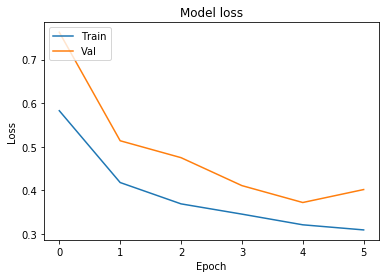

In [9]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8513


## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.

## Fashion MNIST CNN

In [12]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# X shape was (60000, 28, 28) NHW BW, converting it to (60000, 28, 28, 1) NHWC RGB
dim = (28, 28)

def to_rgb(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb

rgb_list_train = []
#convert X_train data to 48x48 rgb values
for i in range(len(X_train)):
    rgb = to_rgb(X_train[i])
    rgb_list_train.append(rgb)
    #print(rgb.shape)
    
rgb_list_test = []
for i in range(len(X_test)):
    rgb = to_rgb(X_test[i])
    rgb_list_test.append(rgb)

rgb_arr_train = np.stack([rgb_list_train],axis=4)
rgb_arr_test = np.stack([rgb_list_test],axis=4)

X_train_3D = np.squeeze(rgb_arr_train, axis=4).astype("float32") / 255.0
X_test_3D = np.squeeze(rgb_arr_test, axis=4).astype("float32") / 255.0

# one hot encode y
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {X_train_3D.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 3), y_train shape: (60000, 10)


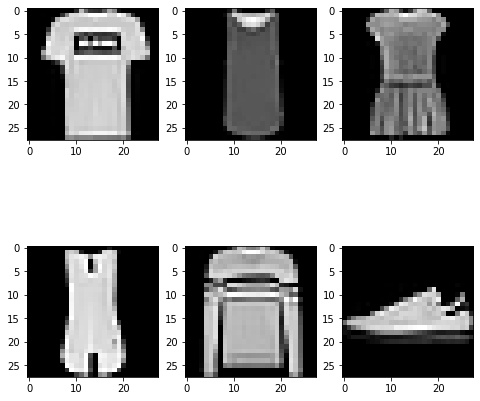

In [13]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train_3D[i])
plt.show();

In [14]:
inputs = Input(shape=(28, 28, 3))#X_train.shape[1:])

# a layer instance is callable on a tensor, and returns a tensor
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
cnn = Model(inputs=inputs, outputs=predictions)
cnn.compile(optimizer='rmsprop',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = cnn.fit(X_train_3D, y_train, batch_size=512, validation_split=0.25, epochs=12, verbose=1)

Train on 45000 samples, validate on 15000 samples
Epoch 1/12
45000/45000 [==============================] - 13s 296us/sample - loss: 0.9738 - acc: 0.7394 - val_loss: 3.6185 - val_acc: 0.1039
Epoch 2/12
45000/45000 [==============================] - 10s 213us/sample - loss: 0.4218 - acc: 0.8469 - val_loss: 2.4120 - val_acc: 0.3475
Epoch 3/12
45000/45000 [==============================] - 10s 213us/sample - loss: 0.3413 - acc: 0.8754 - val_loss: 2.4610 - val_acc: 0.4743
Epoch 4/12
45000/45000 [==============================] - 9s 211us/sample - loss: 0.3025 - acc: 0.8920 - val_loss: 1.3644 - val_acc: 0.5869
Epoch 5/12
45000/45000 [==============================] - 10s 213us/sample - loss: 0.2738 - acc: 0.9005 - val_loss: 0.6180 - val_acc: 0.7783
Epoch 6/12
45000/45000 [==============================] - 10s 211us/sample - loss: 0.2531 - acc: 0.9080 - val_loss: 0.2696 - val_acc: 0.8989
Epoch 7/12
45000/45000 [==============================] - 10s 215us/sample - loss: 0.2393 - acc: 0.9142 -

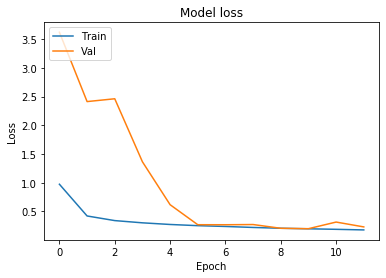

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [16]:
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0   

In [17]:
score = cnn.evaluate(X_test_3D, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9142


## Transfer Learning ResNet50 Fashion-MNIST

In [18]:
# keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [19]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


In [20]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# X shape was (60000, 28, 28) NHW BW, converting it to (60000, 28, 28, 1) NHWC RGB

dim = (28, 28)

def to_rgb(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb

rgb_list_train = []
#convert X_train data to 48x48 rgb values
for i in range(len(X_train)):
    rgb = to_rgb(X_train[i])
    rgb_list_train.append(rgb)
    #print(rgb.shape)
    
rgb_list_test = []
for i in range(len(X_test)):
    rgb = to_rgb(X_test[i])
    rgb_list_test.append(rgb)

rgb_arr_train = np.stack([rgb_list_train],axis=4)
rgb_arr_test = np.stack([rgb_list_test],axis=4)

X_train_3D = np.squeeze(rgb_arr_train, axis=4).astype("float32") / 255.0
X_test_3D = np.squeeze(rgb_arr_test, axis=4).astype("float32") / 255.0

# one hot encode y
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {X_train_3D.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 3), y_train shape: (60000, 10)


In [21]:
inputs = Input(shape=(28, 28, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(10, activation='softmax')(x)

resnet = Model(inputs=base_model.inputs, outputs=predictions)

In [22]:
resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 34, 34, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [23]:
resnet.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=['accuracy'])

history = resnet.fit(X_train_3D, y_train, batch_size=512, validation_split=0.20, epochs=15, verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 20s 423us/sample - loss: 0.9223 - acc: 0.7048 - val_loss: 2.8681 - val_acc: 0.1003
Epoch 2/15
48000/48000 [==============================] - 13s 273us/sample - loss: 0.5654 - acc: 0.7983 - val_loss: 4.0681 - val_acc: 0.1003
Epoch 3/15
48000/48000 [==============================] - 13s 275us/sample - loss: 0.4726 - acc: 0.8284 - val_loss: 3.8475 - val_acc: 0.1007
Epoch 4/15
48000/48000 [==============================] - 13s 275us/sample - loss: 0.4104 - acc: 0.8529 - val_loss: 3.7370 - val_acc: 0.1667
Epoch 5/15
48000/48000 [==============================] - 13s 270us/sample - loss: 0.3561 - acc: 0.8721 - val_loss: 4.0288 - val_acc: 0.1192
Epoch 6/15
48000/48000 [==============================] - 13s 272us/sample - loss: 0.3248 - acc: 0.8818 - val_loss: 4.2743 - val_acc: 0.1035
Epoch 7/15
48000/48000 [==============================] - 13s 275us/sample - loss: 0.2911 - acc: 0.8953 

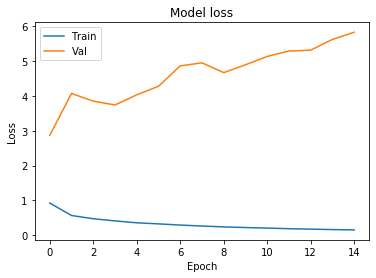

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [25]:
score = resnet.evaluate(X_test_3D, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.1176
